### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 3 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 03 мая, -4 балла после 08:30 10 мая, -6 баллов после 08:30 17 мая, -8 баллов после 08:30 24 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

plt.style.use('ggplot')

In [55]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        self.used_feature = set()
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        
    def __termination(self, y, depth):
        """
        Определяем, пора ли закончить построение дерева
        Если глубина меньше максимальной, в листе не все объекты одного класса и
        число объектов больше минимального, то False
        """
        return not (depth < self.max_depth and np.unique(y).size != 1 and y.shape[0] > self.min_samples_split)
    
    def __gini(self, y_left, y_right):
        """Подсчитаем индекс Джини"""
        if y_left.shape[0] == 0 or y_right.shape[0] == 0:
            return -99999
        score = 0
        leftsize = y_left.shape[0]
        rightsize = y_right.shape[0]
        size = leftsize + rightsize
        leftprob = np.bincount(y_left) / leftsize
        rightprob = np.bincount(y_right) / rightsize
        score -= (1 - np.sum(leftprob ** 2)) * (leftsize / size)
        score -= (1 - np.sum(rightprob ** 2)) * (rightsize / size)
        return score
    
    def __entropy(self, y_left, y_right):
        """Подсчитаем энтропийный критерий"""
        if y_left.shape[0] == 0 or y_right.shape[0] == 0:
            return -99999
        score = 0
        leftsize = y_left.shape[0]
        rightsize = y_right.shape[0]
        size = leftsize + rightsize
        leftprob = np.bincount(y_left) / leftsize
        rightprob = np.bincount(y_right) / rightsize
        score -= (-np.sum(leftprob * np.log2(1e-8 + leftprob))) * (leftsize / size)
        score -= (-np.sum(rightprob * np.log2(1e-8 + rightprob))) * (rightsize / size)
        return score
    
    def __misclassification(self, y_left, y_right):
        """Подсчитаем ошибку классификации"""
        if y_left.shape[0] == 0 or y_right.shape[0] == 0:
            return -99999
        score = 0
        leftsize = y_left.shape[0]
        rightsize = y_right.shape[0]
        size = leftsize + rightsize
        leftprob = np.bincount(y_left) / leftsize
        rightprob = np.bincount(y_right) / rightsize
        score -= (1 - np.max(leftprob)) * (leftsize / size)
        score -= (1 - np.max(rightprob)) * (rightsize / size)
        return score
    
    def __calc_score(self, y_left, y_right):
        if self.criterion == 'gini':
            return self.__gini(y_left, y_right)
        elif self.criterion == 'entropy':
            return self.__entropy(y_left, y_right)
        elif self.criterion == 'misclassification':
            return self.__misclassification(y_left, y_right)
        else:
            raise NotImplementedError()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        score, threshold, feature, samples = -99999, -99999, -99999, None
        for tmp_feature in range(x.shape[1]):
            if feature in self.used_feature:
                continue
            for val in np.unique(x[:, tmp_feature]):
                x_left, x_right, y_left, y_right = self.__div_samples(x, y, tmp_feature, val)
                tmp_score = self.__calc_score(y_left, y_right)
                if tmp_score > score:
                    score = tmp_score
                    threshold = val
                    feature = tmp_feature
                    samples = (x_left, x_right, y_left, y_right)
        self.used_feature.add(feature)
        self.feature_importances_[feature] += 1 - score
        return threshold, feature, samples
        
    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if not self.__termination(y, depth):
            threshold, feature, samples = self.__find_threshold(x, y)
            self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, feature, threshold)
            self.__fit_node(samples[0], samples[2], 2 * node_id + 1, depth + 1)
            self.__fit_node(samples[1], samples[3], 2 * node_id + 2, depth + 1)
        else:
            count = np.bincount(y)
            pred = np.argmax(count)
            prob = count[pred] / y.shape[0]
            self.tree[node_id] = (self.__class__.LEAF_TYPE, pred, prob)
        pass
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.feature_importances_ = [0] * x.shape[1]
        self.__fit_node(x, y, 0, 1) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance():
        """
        Возвращает важность признаков
        """
        return self.feature_importances_

In [7]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [8]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [9]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [10]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.8888888888888888


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [29]:
%time clf.fit(X_train, y_train)

Wall time: 1.99 ms


DecisionTreeClassifier()

In [30]:
%time my_clf.fit(X_train, y_train)

Wall time: 19.9 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [56]:
df = pd.read_csv('./data/Speed Dating Data.csv', encoding='latin1')

df = df.iloc[:, :97]
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)
df = df.drop(['condtn'], axis=1)
df = df.drop(['round'], axis=1)
df = df.drop(['position', 'positin1'], axis=1)
df = df.drop(['order'], axis=1)
df = df.drop(['partner'], axis=1)
df = df.drop(['age_o', 'race_o', 'pf_o_att', 'pf_o_sin',
              'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o'],
             axis=1)
df = df.dropna(subset=['age'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19) # should it be encoded (same for race, career...)
df = df.drop(['field'], axis=1)
df = df.drop(['undergra'], axis=1)

df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(float)
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].fillna(0)

df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(float)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].fillna(0) # mean or 0?

df = df.dropna(subset=['imprelig', 'imprace'])
df = df.drop(['from', 'zipcode'], axis=1)

df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(float)
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(df['income'].mean())

df = df.dropna(subset=['goal', 'date', 'go_out'])

df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
df = df.drop(['career'], axis=1)

df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)
df = df.drop(['expnum'], axis=1)

feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis=1)

feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis=1)

for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)
    
df = df.drop(['wave'], axis=1)

df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
df_female.columns = df_female.columns + '_f'
df_female = df_female.rename(columns={'iid_f': 'pid'})
result = df_male.merge(df_female, on=['pid'], how='inner')

target = result['match']

result = result.drop(['pid_f', 'match'], axis=1)

# упростим оставшееся
result['field_cd'] = (result['field_cd'] - result['field_cd_f'] == 0).astype(int)
result['career_c'] = (result['career_c'] - result['career_c_f'] == 0).astype(int)
result = result.drop(['field_cd_f', 'career_c'], axis=1)
result['date'] = (result['date'] - result['date_f']) ** 2
result['go_out'] = (result['go_out'] - result['go_out_f']) ** 2
result['goal'] = (result['goal'] - result['goal_f']) ** 2
result = result.drop(['date_f', 'go_out_f', 'goal_f'], axis=1)

result.head()

,iid,pid,int_corr,samerace,age,field_cd,mn_sat,tuition,race,imprace,...,sinc2_1_f,intel2_1_f,fun2_1_f,amb2_1_f,shar2_1_f,attr3_1_f,sinc3_1_f,fun3_1_f,intel3_1_f,amb3_1_f
0,11,1.0,0.14,0,27.0,0,0.0,0.0,2.0,7.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
1,12,1.0,0.54,0,22.0,1,0.0,0.0,2.0,1.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
2,13,1.0,0.16,1,22.0,1,0.0,0.0,4.0,3.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
3,14,1.0,0.61,0,23.0,1,0.0,0.0,2.0,1.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
4,15,1.0,0.21,0,24.0,1,0.0,0.0,3.0,3.0,...,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [57]:
X_train, X_test, y_train, y_test = train_test_split(np.asarray(result), np.asarray(target),
                                                    test_size=0.3, stratify=np.asarray(target))

In [58]:
res = {}

for criterion in ['gini', 'entropy', 'misclassification']:
    print(criterion + '...')
    res[criterion] = []
    for depth in range(3, 10):
        for samples_split in range(2, 10):
            my_clf = MyDecisionTreeClassifier(criterion=criterion,
                                              max_depth=depth, min_samples_split=samples_split)
            my_clf.fit(X_train, y_train)
            prediction= my_clf.predict(X_test)
            acc = accuracy_score(prediction, y_test)
            res[criterion].append((acc, depth, samples_split))

gini...
entropy...
misclassification...


In [59]:
max(res['gini']), max(res['entropy']), max(res['misclassification'])

((0.8391666666666666, 4, 9),
 (0.8366666666666667, 9, 8),
 (0.8391666666666666, 6, 9))

[]

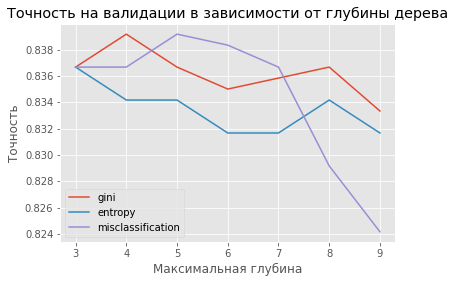

In [60]:
for criterion in res.keys():
    acc, depth = [], []
    for i in res[criterion][::8]:
        acc.append(i[0])
        depth.append(i[1])
    plt.plot(depth, acc, label=criterion)
plt.title('Точность на валидации в зависимости от глубины дерева')
plt.xlabel('Максимальная глубина')
plt.ylabel('Точность')
plt.legend()
plt.plot()

[]

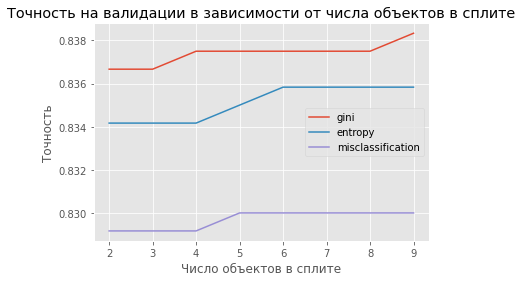

In [65]:
for criterion in res.keys():
    acc, split = [], []
    for i in res[criterion][40:48]:
        acc.append(i[0])
        split.append(i[2])
    plt.plot(split, acc, label=criterion)
plt.title('Точность на валидации в зависимости от числа объектов в сплите')
plt.xlabel('Число объектов в сплите')
plt.ylabel('Точность')
plt.legend()
plt.plot()

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [77]:
my_clf = MyDecisionTreeClassifier(criterion='misclassification', max_depth=9, min_samples_split=6)
my_clf.fit(np.asarray(result), np.asarray(target))
result.columns[np.argsort(my_clf.feature_importances_)[-10:]][::-1]

Index(['iid', 'pid', 'int_corr', 'exphappy', 'amb2_1', 'fun2_1', 'intel2_1',
       'sinc2_1', 'attr2_1', 'shar1_1'],
      dtype='object')

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



В этом дз особенно сложно показалось с предобработкой датасета.